In this profile, we will perform tree based models in classification task.

In [ ]:
load("8.1ForClassification.RData")

In [13]:
library(tree)
library(randomForest)
library(gbm)
library(pROC)
library(DMwR2)
library(mlbench)
library(MASS)

# 1 Process data
Although tree model can handle missing values without explict processing steps, it's still important to be mindful of the potential implications and consider the impact of missingness on the model's performance, interpretation, and any downstream analysis. So, we impute missing values in this example. 

For binary classification, we can use either numeric or factor. 
We use factor y in decision tree/ bagging/ random forests as numberic y will be treated as regression task.
We use numeric y in gbm as factor type of y will return NAs' cofficient.

In [2]:
data("PimaIndiansDiabetes2")
cdata <- PimaIndiansDiabetes2
head(cdata)

cat("Sum of NAs in cdata is", sum(is.na(cdata)))
manyNAs(t(cdata), nORp = 0.1)
cdata <- cdata[, -manyNAs(t(cdata), nORp = 0.1)]
dim(cdata)
cdata <- knnImputation(data = cdata, k = 10, scale = T, meth = "weighAvg", distData = NULL)
cat("Sum of NAs in imputed cdata", sum(is.na(cdata)))
cdata$diabetes <- as.numeric(cdata$diabetes)
head(cdata, n = c(2, 7))
cdata <- transform(cdata, diabetes = diabetes -1)
cdata$diabetes <- factor(cdata$diabetes)
head(cdata)
set.seed(0)
ctrain <- sample(1: nrow(cdata), size = nrow(cdata) * 0.8)
cy.test <- cdata$diabetes[-ctrain]

,pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age,diabetes
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,6,148,72,35,NA,33.6,0.627,50,pos
2,1,85,66,29,NA,26.6,0.351,31,neg
3,8,183,64,NA,NA,23.3,0.672,32,pos
4,1,89,66,23,94,28.1,0.167,21,neg
5,0,137,40,35,168,43.1,2.288,33,pos
6,5,116,74,NA,NA,25.6,0.201,30,neg


Sum of NAs in cdata is 652

triceps insulin 
      4       5

[1] 768   7

Sum of NAs in imputed cdata 0

,pregnant,glucose,pressure,mass,pedigree,age,diabetes
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,6,148,72,33.6,0.627,50,2
2,1,85,66,26.6,0.351,31,1


,pregnant,glucose,pressure,mass,pedigree,age,diabetes
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,6,148,72,33.6,0.627,50,1
2,1,85,66,26.6,0.351,31,0
3,8,183,64,23.3,0.672,32,1
4,1,89,66,28.1,0.167,21,0
5,0,137,40,43.1,2.288,33,1
6,5,116,74,25.6,0.201,30,0


# 2 Decision Tree

fitting a big decision tree in training data and predicting in testing data

Splitting continues until the terminal nodes are 
too small or too few to be split. 
Regression trees' depth is limited to 31, 
and classfication trees' is 32.


Classification tree:
tree(formula = diabetes ~ ., data = cdata, subset = ctrain)
Variables actually used in tree construction:
[1] "glucose"  "mass"     "age"      "pedigree"
Number of terminal nodes:  12 
Residual mean deviance:  0.8768 = 527.9 / 602 
Misclassification error rate: 0.2068 = 127 / 614 

The auc is 0.8649038
The accuracy is 0.7922078

             cy.test
cbigtree.pred  0  1
            0 86 14
            1 18 36

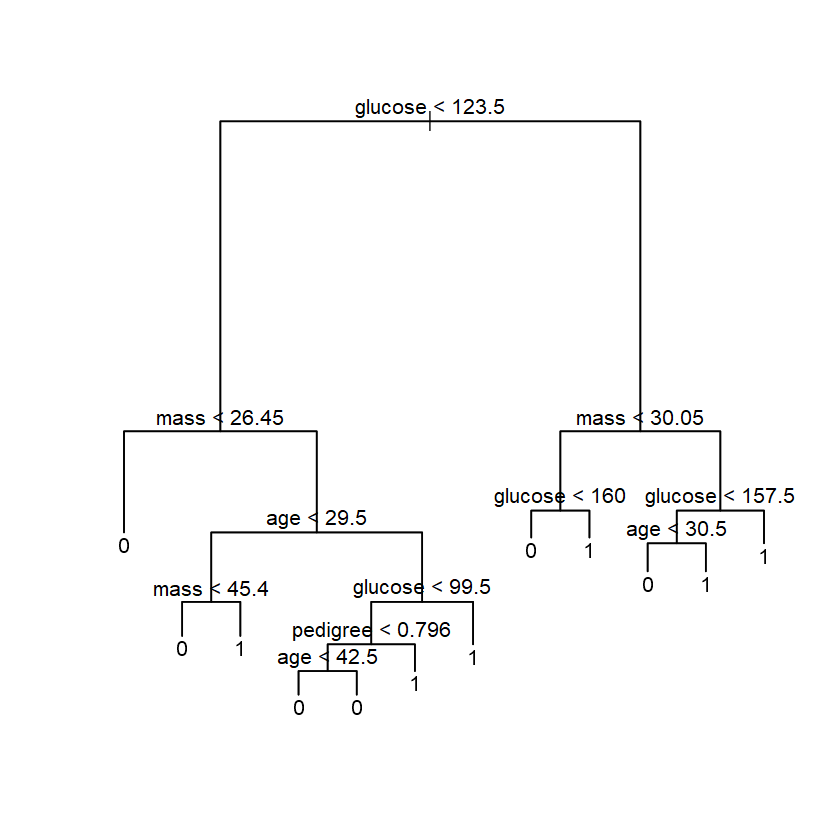

In [3]:
cbigtree <- tree(diabetes~. , data = cdata, subset = ctrain)
cat("Splitting continues until the terminal nodes are 
too small or too few to be split. 
Regression trees' depth is limited to 31, 
and classfication trees' is 32.")
summary(cbigtree)
plot(cbigtree)
text(cbigtree, pretty = 0)
cbigtree.prob <- predict(cbigtree, newdata = cdata[-ctrain, ], type = "vector")[, 2]
cat("The auc is", auc(response = cdata$diabetes[-ctrain], predictor = cbigtree.prob, levels = c(0, 1), direction = "<"))
cbigtree.pred <- predict(cbigtree, newdata = cdata[-ctrain, ], type = "class")
cat("\nThe accuracy is", sum(cbigtree.pred == cy.test) / length(cy.test))
table(cbigtree.pred, cy.test)

prune---using cross-validation to select the best $\alpha$

FUN=prune.misclass - means we want classification error rate instead of devience to select the best tree


$size
[1] 12 11  6  4  3  2  1

$dev
[1] 174 174 175 171 161 175 219

$k
[1] -Inf  0.0  1.8  3.0  5.0 24.0 47.0

$method
[1] "misclass"

attr(,"class")
[1] "prune"         "tree.sequence"

Note: 1.k means alpha in prune loss
      2.despite the name, 'dev' correspond to the cross-validation error rate in this instance
The best size of the tree is 3

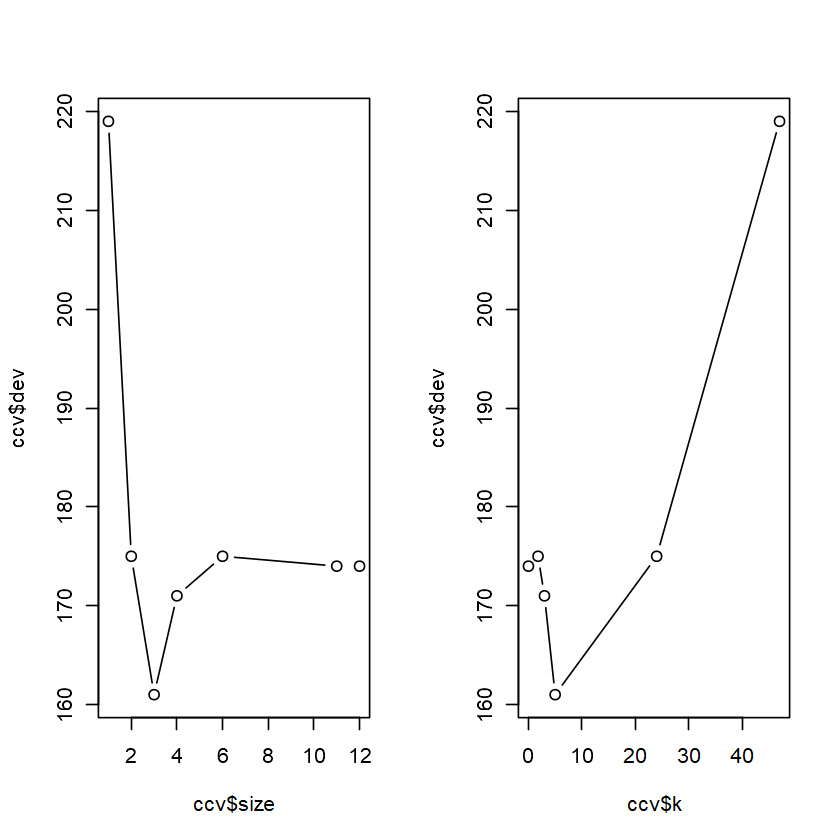

In [4]:
set.seed(1)
cat("FUN=prune.misclass - means we want classification error rate instead of devience to select the best tree
")
ccv <- cv.tree(cbigtree, FUN = prune.misclass)
ccv
cat("Note: 1.k means alpha in prune loss\n")
cat("      2.despite the name, 'dev' correspond to the cross-validation error rate in this instance\n")
cat("The best size of the tree is", ccv$size[which.min(ccv$dev)])
par(mfrow = c(1, 2))
plot(ccv$size, ccv$dev, type = "b")
plot(ccv$k, ccv$dev, type="b")

prune---getting best subtree and predicting

The auc is 0.7855769


The accuracy is 0.7922078

           cy.test
cprune.pred  0  1
          0 90 18
          1 14 32

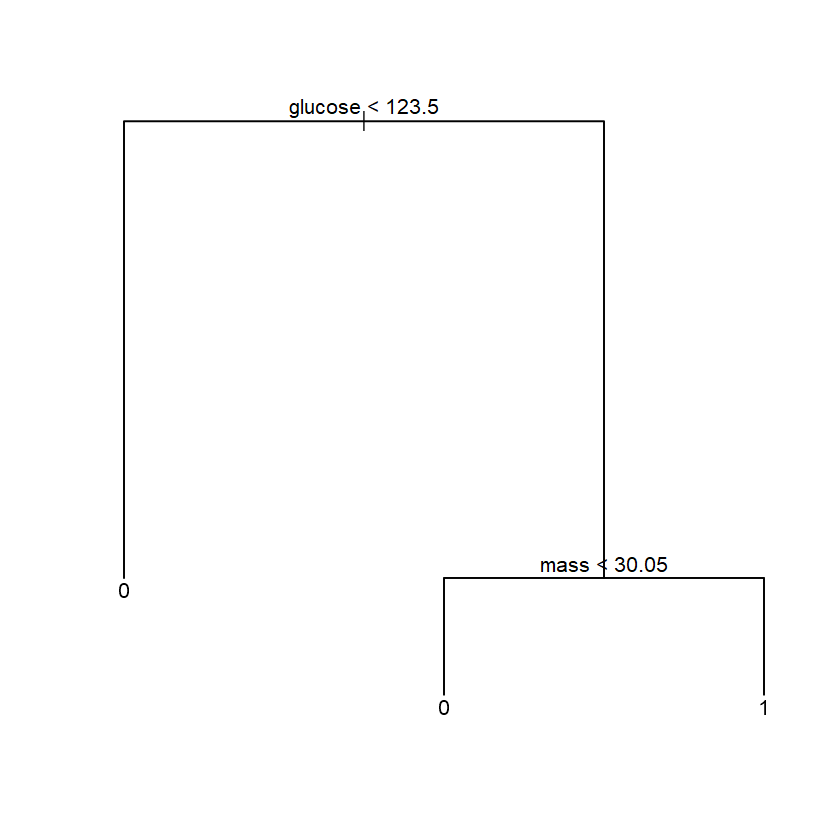

In [5]:
cprune <- prune.misclass(tree = cbigtree, best = ccv$size[which.min(ccv$dev)])
plot(cprune)
text(cprune, pretty = 0)
cprune.prob <- predict(cprune, newdata = cdata[-ctrain, ], type = "vector")[, 2]
cat("The auc is", auc(response = cy.test, predictor = cprune.prob, levels = c(0, 1), direction = "<"))
cprune.pred <- predict(cprune, newdata = cdata[-ctrain, ], type = "class")
cat("\nThe accuracy is", sum(cprune.pred == cy.test) / length(cy.test))
table(cprune.pred, cy.test)

# 3. Bagging and Random Forests
By default, randomForest()
uses p/3 variables when building a random forest of regression trees, and
$\sqrt{p}$ variables when building a random forest of classification trees.

bagging


Call:
 randomForest(formula = diabetes ~ ., data = cdata, mtry = 6,      type = "classification", importance = TRUE, subset = ctrain) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 6

        OOB estimate of  error rate: 24.59%
Confusion matrix:
    0   1 class.error
0 324  72   0.1818182
1  79 139   0.3623853

The auc using 500 trees is 0.8867308
The accuracy using 500 trees is 0.8376623

         cy.test
cbag.pred  0  1
        0 96 17
        1  8 33

The auc using 50 trees is 0.8593269
The accuracy using 50 trees is 0.8116883

                 cy.test
cbag.50trees.pred  0  1
                0 95 20
                1  9 30

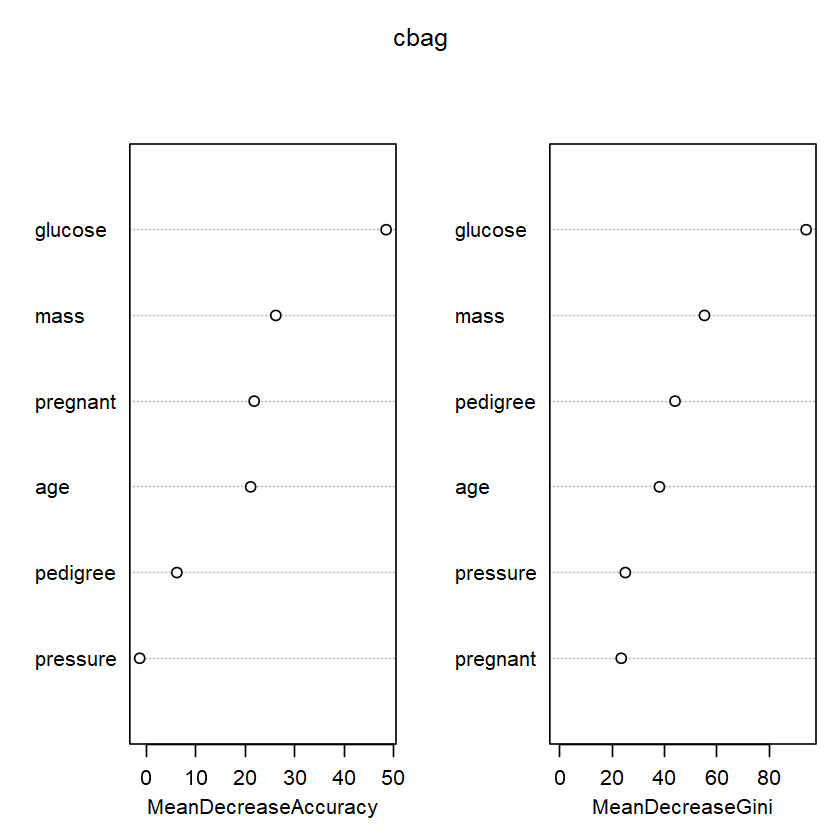

In [6]:
set.seed(0)
cbag <- randomForest(diabetes~., data = cdata, subset = ctrain, mtry = 6, type = "classification", importance = TRUE)
cbag
cbag.prob <- predict(cbag, newdata = cdata[-ctrain, ], type = "prob")[, 2] # vote
cat("The auc using 500 trees is", auc(response = cy.test, predictor = cbag.prob, levels = c(0, 1), direction = "<"))
cbag.pred <- predict(cbag, newdata = cdata[-ctrain, ], type = "response")
cat("\nThe accuracy using 500 trees is", sum(cbag.pred == cy.test) / length(cy.test))
table(cbag.pred, cy.test)
cbag.50trees <- randomForest(diabetes~., data = cdata, subset = ctrain, mtry = 6, type = "classification", importance = TRUE, ntree = 50)
cbag.50trees.prob <- predict(cbag.50trees, newdata = cdata[-ctrain, ], type = "prob")[, 2]
cat("The auc using 50 trees is", auc(response = cy.test, predictor = cbag.50trees.prob, levels = c(0, 1), direction = "<"))
cbag.50trees.pred <- predict(cbag.50trees, newdata = cdata[-ctrain, ], type = "class")
cat("\nThe accuracy using 50 trees is", sum(cbag.50trees.pred == cy.test) / length(cy.test))
table(cbag.50trees.pred, cy.test)
varImpPlot(cbag)

random forests


Call:
 randomForest(formula = diabetes ~ ., data = cdata, type = "classification",      mtry = 4, importance = TRUE, ntree = 500, subset = ctrain) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 4

        OOB estimate of  error rate: 24.76%
Confusion matrix:
    0   1 class.error
0 327  69   0.1742424
1  83 135   0.3807339

The auc using 500 trees is 0.8881731
The accuracy using 500 trees is 0.8441558

        cy.test
cff.pred  0  1
       0 97 17
       1  7 33


The auc using 50 trees is 0.8753846
The accuracy using 50 trees is 0.8181818

                cy.test
cff.50trees.pred  0  1
               0 93 17
               1 11 33

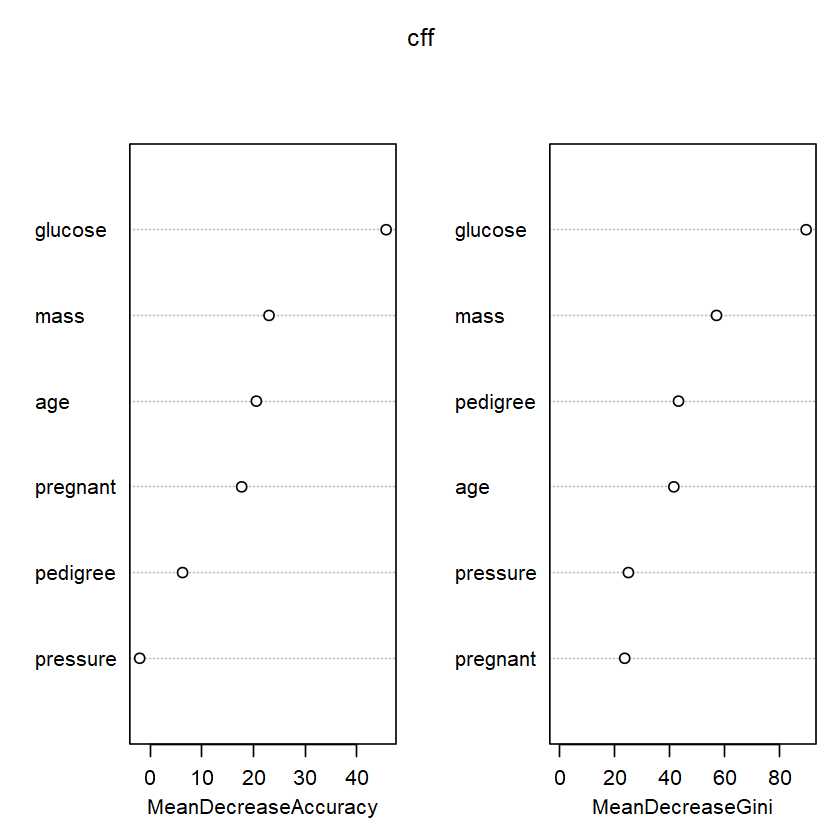

In [7]:
set.seed(0)
cff <- randomForest(diabetes~., data = cdata, subset = ctrain, type = "classification", mtry = 4, importance = TRUE, ntree = 500)
cff
cff.prob <- predict(cff, newdata = cdata[-ctrain, ], type = "prob")[, 2]
cat("The auc using 500 trees is", auc(response = cy.test, predictor = cff.prob, levels = c(0, 1), direction = "<"))
cff.pred <- predict(cff, newdata = cdata[-ctrain, ], type = "class")
cat("\nThe accuracy using 500 trees is", sum(cff.pred == cy.test) / length(cy.test))
table(cff.pred, cy.test)
cff.50trees <- randomForest(diabetes~., data = cdata[ctrain, ], type = "classification", mtry = 4, importance = TRUE, ntree = 50)
cff.50trees.prob <- predict(cff.50trees, newdata = cdata[-ctrain, ], type = "prob")[, 2]
cat("\nThe auc using 50 trees is", auc(response = cy.test, predictor = cff.50trees.prob, levels = c(0, 1), direction = "<"))
cff.50trees.pred <- predict(cff.50trees, newdata = cdata[-ctrain, ], type = "class")
cat("\nThe accuracy using 50 trees is", sum(cff.50trees.pred == cy.test) / length(cy.test))
table(cff.50trees.pred, cy.test)
varImpPlot(cff)

# 4. Bosting

transfer factor y to numeric y

In [8]:
cdata$diabetes <- as.numeric(cdata$diabetes)
cdata$diabetes <- cdata$diabetes - 1

In [9]:
cbost <- gbm(diabetes~., data = cdata[ctrain, ], 
    distribution = "bernoulli", n.trees = 1000, 
    interaction.depth = 4, shrinkage = 0.01)
cbost
summary(cbost, plot = FALSE)
cbost.prob <- predict(cbost, newdata = cdata[-ctrain, ], type = "response", n.trees = 1000)
# cbost.pred <- predict(cbost, newdata = cdata[-ctrain, ], type = "link")
cat("The auc is", auc(response = cy.test, predictor = cbost.prob, levels = c(0, 1), direction = "<"))
cbost.pred <- ifelse(cbost.prob >= 0.5, yes = 1, no = 0)
cat("\nThe accuracy is", sum(cbost.pred == cy.test) / length(cy.test))
table(cbost.pred, cy.test)

gbm(formula = diabetes ~ ., distribution = "bernoulli", data = cdata[ctrain, 
    ], n.trees = 1000, interaction.depth = 4, shrinkage = 0.01)
A gradient boosted model with bernoulli loss function.
1000 iterations were performed.
There were 6 predictors of which 6 had non-zero influence.

,var,rel.inf
,<chr>,<dbl>
glucose,glucose,34.846043
mass,mass,21.291370
age,age,16.092708
pedigree,pedigree,14.564658
pregnant,pregnant,7.329443
pressure,pressure,5.875778


The auc is 0.8794231
The accuracy is 0.8181818

          cy.test
cbost.pred  0  1
         0 94 18
         1 10 32

# 5.Save Environment

In [15]:
save.image("8.1ForClassification.RData")